# cluster isolation

## references

[*Quantitative measures of cluster quality for use in extracellular recordings*, Schmitzer-Torbert et al. 2005](https://doi.org/10.1016/j.neuroscience.2004.09.066)

c.f.
* relectro package implementation
    * `relectro/man/isolationDistance-methods.Rd`
    * `relectro/R/SpikeTrain.R`

* spikeA implementation for previous publication
    * `Jazi_et.al_2023_noInt/ExtDataFig11/ExtendedData_fig11.ipynb`

## load spikeA session

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session
from spikeA.Intervals import Intervals

In [2]:
path,name = "/adata/electro/pk4926/pk4926-26042024-0101", "pk4926-26042024-0101"

In [3]:
ses = Kilosort_session(name=name, path=path)
ses.load_parameters_from_files()
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk4926-26042024-0101
path = /adata/electro/pk4926/pk4926-26042024-0101
subject = pk4926
session_dat_time = 2024-04-26 01:01:00
fileBase = /adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101
file_names = {'par': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.par', 'desen': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.desen', 'desel': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.desel', 'sampling_rate': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.sampling_rate_dat', 'stimulation': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.stimulation', 'px_per_cm': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.px_per_cm', 'setup': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.setup', 'environmentFamiliarity': '/adata/electro/pk4926/pk4926-26042024-0101/pk4926-26042024-0101.environmentFamiliarity', 'params':

In [4]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)
len(cg.neuron_list)

stl.clu_ids [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  19
  20  21  23  26  27  28  29  31  32  35  36  37  38  39  40  41  42  43
  44  46  47  48  49  50  51  52  53  54  55  57  58  59  61  62  63  64
  65  66  68  69  70  71  72  73  75  76  77  80  81  82  83  84  85  86
  87  88  89  92  93  94  96  97  98  99 100 101 102 104 105 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 123 124 126 127 129 130]


108

## calculate isolation distance

In [5]:
cg.set_info_from_session(ses,1)

In [6]:
from scipy.spatial import distance
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html

In [7]:
# get all clusters on same shank as this cell

# 1. get shank for neuron
def get_shank(n):
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(n.channels)
    shank = active_shanks[0]
    return shank

# 2. get clusters on that shank
def clusters_on_shank(shank):
    cluOnshk = []
    for i,n in enumerate(cg.neuron_list):
        shanks_arr, active_shanks, electrodes = ses.get_active_shanks(n.channels)
        if shank in active_shanks:
            cluOnshk.append(n.cluster_number)
    return cluOnshk


In [8]:
# load pc features
pcf = np.load(ses.path+'/pc_features.npy') ## [nSpikes, nFeaturesPerChannel, nPCFeatures] single
pcf.shape

(1772250, 3, 32)

In [9]:
ses.sc.shape # spike cluster assignment

(1772250,)

In [10]:
# some example neuron
n = cg.neuron_list[0]
n.name, n.cluster_number

('0', 0)

In [11]:
shank = int(get_shank(n))
cluOnshk = clusters_on_shank(shank)
print("neuron is active on shank {} and so many clusters are on that shank too: {}".format(shank,len(cluOnshk)))

neuron is active on shank 1 and so many clusters are on that shank too: 59


In [12]:
ind1 = (ses.sc == n.cluster_number) ### index of the spikes for this clu
pcf_clu1 = pcf[ind1]
pcf_clu1.shape

(11369, 3, 32)

In [13]:
## get the features of the spikes assigned to that cluster
## reshape to get all fet from all channels
pcfClu1 = pcf_clu1.reshape((pcf_clu1.shape[0],pcf_clu1.shape[1]*pcf_clu1.shape[2]))
MeanClu1 = np.mean(pcfClu1, axis = 0)
Covclu1 = np.cov(pcfClu1.T)
pcfClu1.shape, MeanClu1.shape, Covclu1.shape

((11369, 96), (96,), (96, 96))

In [14]:
# loop through all clusters on that shank and get the distance

MedianD=[]
distances=[]
pcf_clus=[] ## pc features for all spikes for all clusters
Id_clus=[] ## cluster number for corresponding pc features

for clu in tqdm(cluOnshk):
    ind = (ses.sc == clu) ### index of the spikes for this clu
    pcf_clu = pcf[ind]
    pcfClu = pcf_clu.reshape((pcf_clu.shape[0],pcf_clu.shape[1]*pcf_clu.shape[2])) ## pc features for all spikes of that clu
    pcf_clus.append(pcfClu)
    Id_clus.append([clu]*len(pcfClu))

    res = np.array([distance.mahalanobis(u,MeanClu1,Covclu1) for u in pcfClu])
    distances.append(np.transpose([res,[clu]*len(res)]))
    MedianD.append(np.median(res))
    #print(np.median(res),clu)


100%|███████████████████████████████████████████| 59/59 [00:43<00:00,  1.37it/s]


In [15]:
distances = np.concatenate(distances)
MedianDneuron = np.median(distances[distances[:,1]==n.cluster_number,0])
pcf_clus = np.concatenate(pcf_clus)
Id_clus = np.concatenate(Id_clus)
distances_sorted = np.array(sorted(distances,key=lambda x:x[0])) # sort by distance, it will start with the spikes within the cluster and have the noise spikes later

ind = distances_sorted[:,1]==n.cluster_number

In [16]:
sum(ind),len(ind)

(11369, 924185)

In [17]:
# calculate the isolation score

ratio = np.cumsum(ind)/np.arange(len(ind))
indRatio = ratio<0.5
IsolationScore=np.nan
if np.any(indRatio):
    r=np.arange(len(indRatio))
    indRatio_belowthreshold = np.where([np.all(indRatio[r_:]) for r_ in r])[0]
    if len(indRatio_belowthreshold):
        IsolationScore = distances_sorted[indRatio_belowthreshold[0],0]


/tmp/ipykernel_657859/4152945054.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = np.cumsum(ind)/np.arange(len(ind))


In [18]:
MedianDneuron, np.array(MedianD), distances, distances_sorted, IsolationScore, pcf_clus, Id_clus

(22.571315536653422,
 array([ 22.57131554,  34.09957907,  29.91913718, 114.94093153,
         38.17703536,  39.76500091,  26.40973383,  59.90375315,
         55.28385472,  42.2819805 ,  36.6461653 ,  32.46535334,
         28.9963115 ,  29.33330406,  65.35428435,  36.80507852,
         35.14307261,  59.98715726,  34.97327741, 136.81714571,
        106.02491563,  58.76518355,  33.20351933,  91.83103734,
         53.79256159,  34.74304377,  33.76342447,  30.5243024 ,
         60.88897741,  35.11621676,  54.39937224,  33.23631712,
         37.81305459,  44.90871708,  37.63093361,  31.60614652,
         32.50463751,  30.93777565,  33.08753953,  40.77088261,
         38.09756528,  30.44177804,  27.55274802,  32.36751699,
         31.23052403,  37.40651309,  34.27293745,  28.53499036,
         36.77459955,  36.31533778,  27.33818152,  37.12799853,
         34.28942442,  33.30893602,  34.26481708,  36.49559388,
         27.27858437,  30.37988082,  34.98848842]),
 array([[ 22.30227416,   0.    

Text(0.5, 1.0, 'cluster isolation')

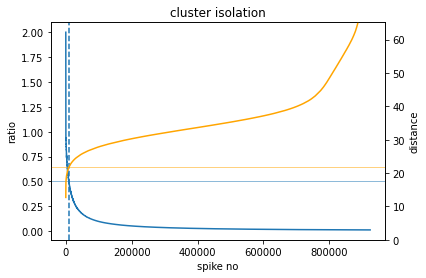

In [19]:
plt.plot(ratio)
plt.ylabel("ratio")
plt.xlabel("spike no")
plt.axhline(y=.5,lw=.5)
plt.axvline(indRatio_belowthreshold[0], ls='dashed')

ax2 = plt.gca().twinx()
ax2.plot(distances_sorted[:,0], c='orange')
plt.axhline(IsolationScore, lw=.5,c='orange')
ax2.set_ylim((0,3*IsolationScore))
ax2.set_ylabel("distance")

plt.title("cluster isolation")

In [20]:
IsolationScore

21.715958412720735